In [1]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
# cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"E:\MS_ExperimentData\general"
MP4_PATH = r"E:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

In [2]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    dt=0.001,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=9, overWrite=True
)
sa = StateAnalysis(model)

In [3]:
classes, centers = sa.calc_classes_and_centers(classDistance=0.5, lookIdx=-1)
tailDotPhaseThetas = np.array([sa.calc_dot_theta(lookIdx=i) for i in np.arange(-100, 0)])
effectiveFreqs = tailDotPhaseThetas.mean(axis=0)

classCenters = np.array([centers[c].mean(axis=0) for c in classes])
edges, ajdClassCenters = sa.calc_nearby_edges(edgeLenThres=1.5, classCenters=classCenters)

classPosPerent = list()
classNegPerent = list()
classMeanPosFreq = list()
classMeanNegFreq = list()
classMeanFreq = list()
classMeanEffFreq = list()

for classIdx, oscIdx in enumerate(classes):
    freqOmega: np.ndarray = sa.model.freqOmega[oscIdx]

    posPerent = (freqOmega >= 0).mean()
    negPerent = (freqOmega < 0).mean()
    
    meanPosFreq = freqOmega[freqOmega >= 0].mean()
    meanNegFreq = freqOmega[freqOmega < 0].mean()

    meanFreq = freqOmega.mean()
    meanEffFreq = effectiveFreqs[oscIdx].mean()
    
    classPosPerent.append(posPerent)
    classNegPerent.append(negPerent)
    classMeanPosFreq.append(meanPosFreq)
    classMeanNegFreq.append(meanNegFreq)
    classMeanFreq.append(meanFreq)
    classMeanEffFreq.append(meanEffFreq)

classPosPerent = np.array(classPosPerent)
classNegPerent = np.array(classNegPerent)
classMeanPosFreq = np.array(classMeanPosFreq)
classMeanNegFreq = np.array(classMeanNegFreq)

edgeLenThres = 1.5

nearbyMeanFreqs = dict()

for i in range(len(classes)):
    selectClassFreq = classMeanFreq[i]
    nearbyMeanFreqs[selectClassFreq] = list()
    relativeDistance = sa.calc_replative_distance(classCenters[i], classCenters)
    nearbyClassIdx = np.where(
        (relativeDistance < edgeLenThres) & (relativeDistance > 0.1)
    )[0]
    for j in nearbyClassIdx:
        nearbyMeanFreqs[selectClassFreq].append(classMeanFreq[j])

xFreqs = list()
yFreqs = list()

for k, v in nearbyMeanFreqs.items():
    xFreqs += [k] * len(v)
    yFreqs += v

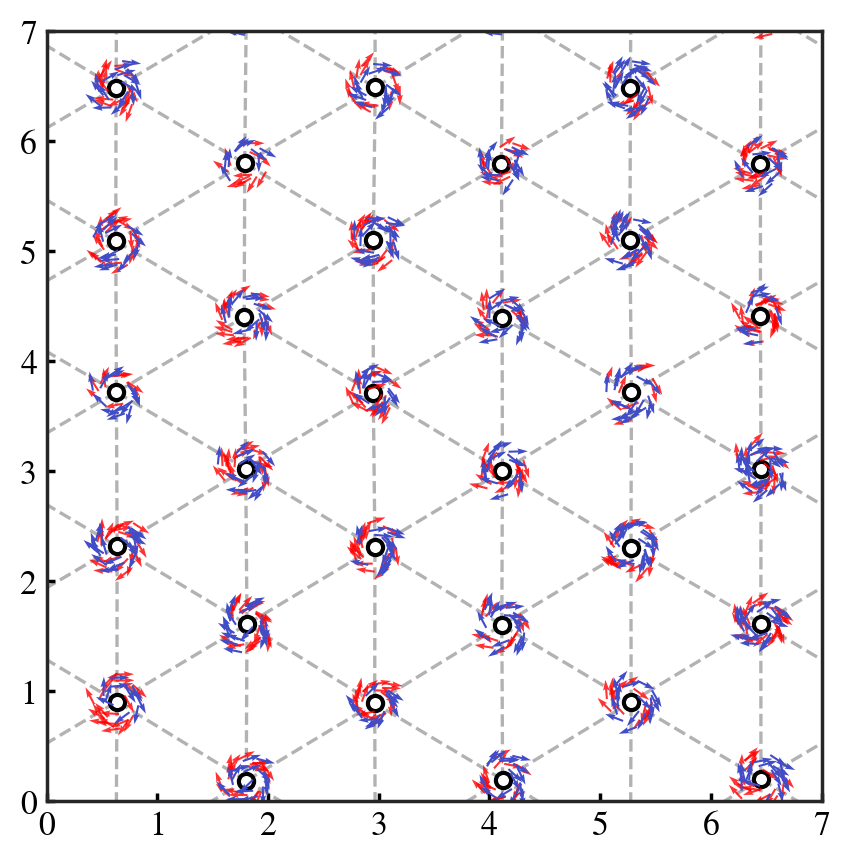

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))

shift = np.array([0.5, 0])

plt.scatter(
    np.mod(classCenters[:, 0] + shift[0], sa.model.boundaryLength), 
    np.mod(classCenters[:, 1] + shift[1], sa.model.boundaryLength),
    facecolor="white", cmap=cmap, s=30, edgecolor="black", lw=1.5
)

for edge in edges[:]:
    plt.plot(ajdClassCenters[edge, 0] + shift[0],
             ajdClassCenters[edge, 1] + shift[1],
             color="black", lw=1.2, alpha=0.3, linestyle="--", zorder=0)


sa.plot_spatial(ax=ax, shift=shift)


# plt.xlim(0 + xShift, sa.model.boundaryLength + xShift)
plt.ylim(0, sa.model.boundaryLength)
# plt.xticks(
#     np.arange(0 + xShift, sa.model.boundaryLength + xShift + 1),
#     np.arange(0, sa.model.boundaryLength + 1))
plt.tick_params(length=3, direction="in")


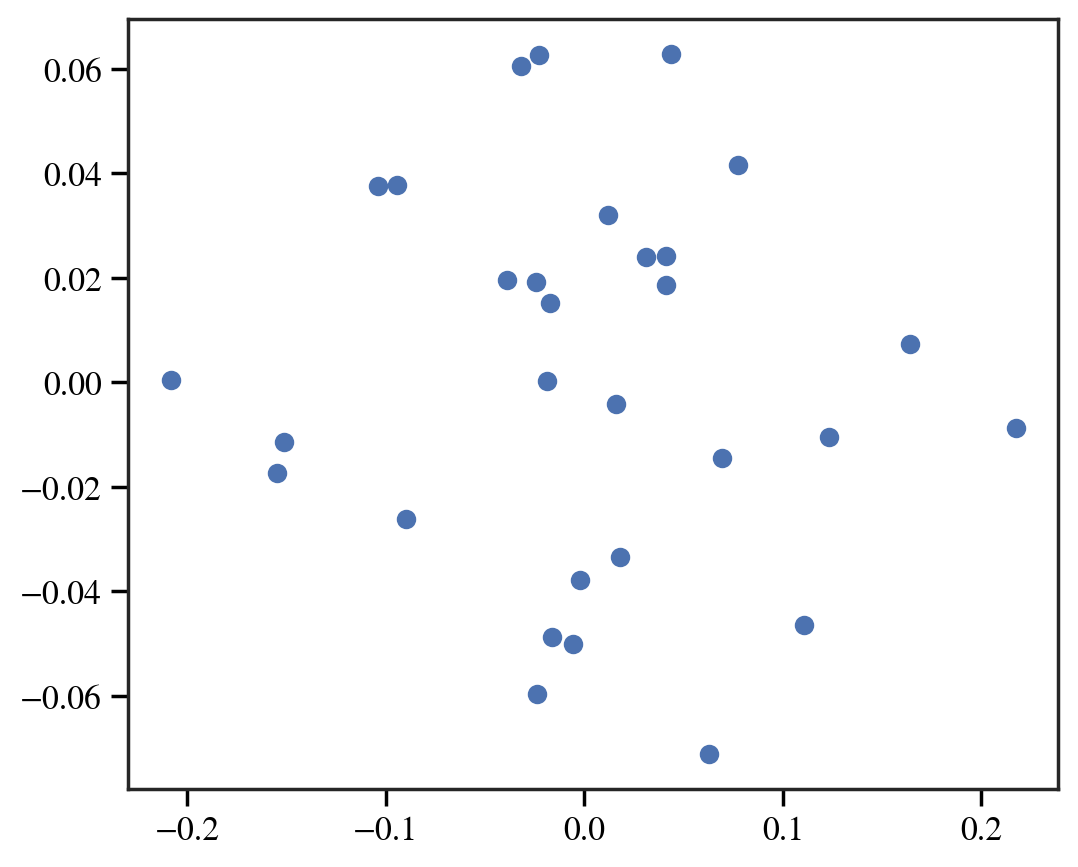

In [5]:
meanNearByFreq = [np.mean(v) for v in nearbyMeanFreqs.values()]
plt.scatter(nearbyMeanFreqs.keys(), meanNearByFreq)

In [3]:
phaseLags = np.linspace(-1, 1, 21) * np.pi
phaseLags = phaseLags[phaseLags != 0]  # Exclude zero phase lag
omegaMins = [0]# [0.1]  # np.linspace(0.1e5, 3, 21)
randomSeed = 10  # Done: [9]
strengthLambda = 20
distanceD0 = 1
deltaOmega = 0  # Done: [1]

models = [
    PhaseLagPatternFormationNoCounter(
        strengthK=strengthLambda, distanceD0=distanceD0, phaseLagA0=phaseLag,
        # initPhaseTheta=np.zeros(1000), 
        omegaMin=omegaMin, deltaOmega=deltaOmega, dt=0.001,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for omegaMin in omegaMins
    for phaseLag in phaseLags
]

sas = [StateAnalysis(model) for model in tqdm(models)]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

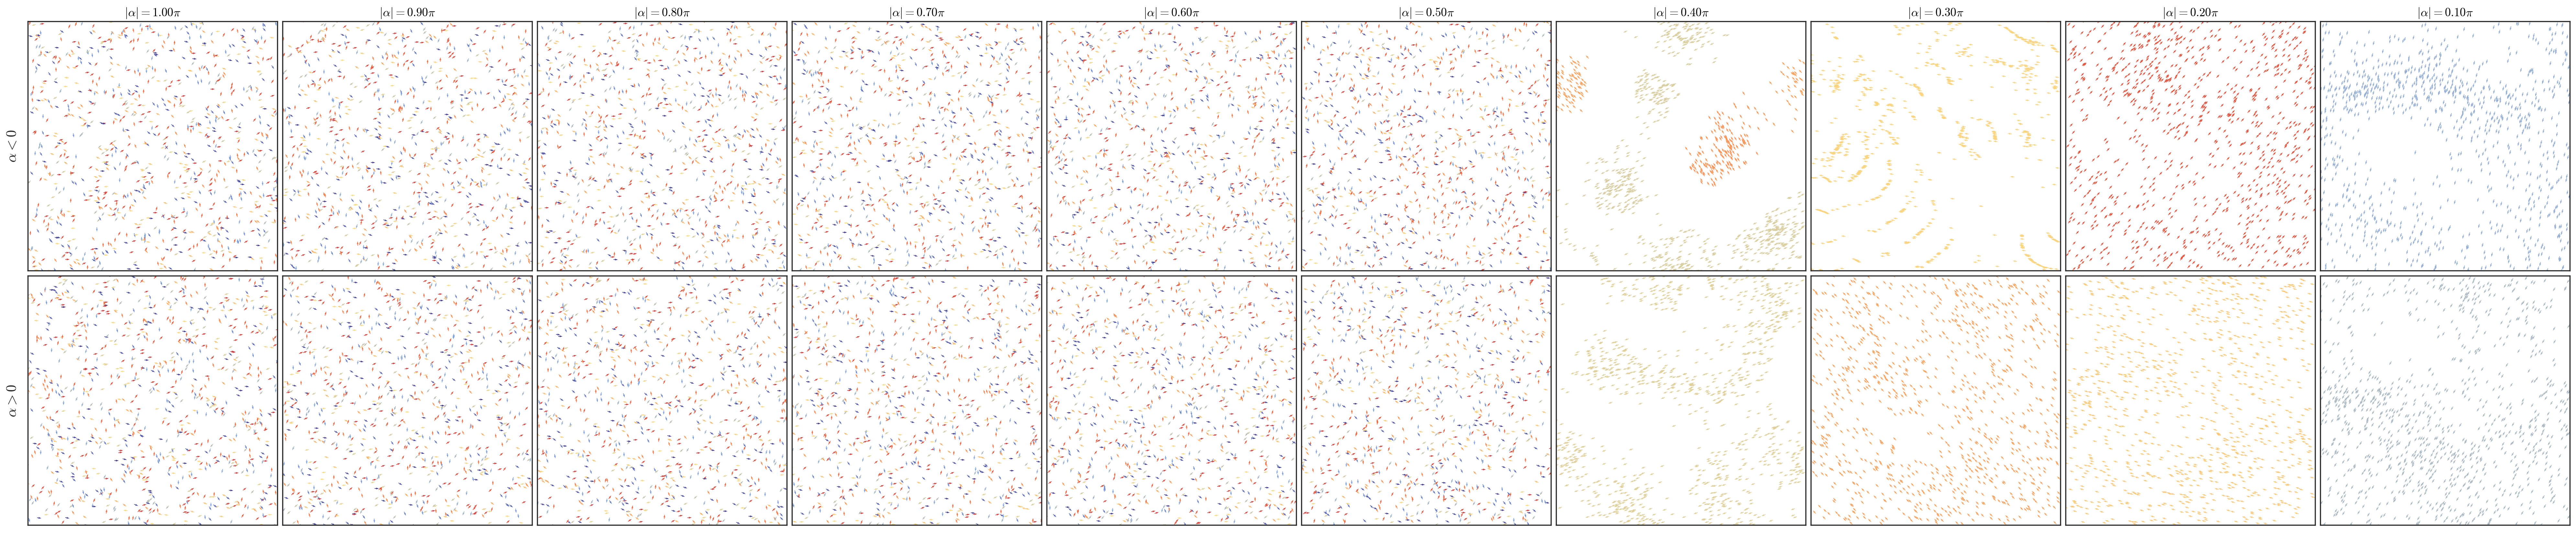

In [4]:
ncols = len(phaseLags) // 2
fig, axs = plt.subplots(
    nrows=2, ncols=ncols, figsize=(ncols * 4, 8.6),
    sharex=True, sharey=True,
)

for i, sa in tqdm(enumerate(sas), total=len(sas)):

    if sa.model.phaseLagA0 == 0:
        continue

    ax = axs[i // ncols, i % ncols if i < ncols else ncols - (i % ncols) - 1]
    sa.plot_spatial(ax, colorsBy="phase")
    subLetter = chr(97 + i)
    ax.set_xticks([])
    ax.set_yticks([])
    if i // ncols == 0:
        ax.set_title(
            rf"$|\alpha|={(np.abs(sa.model.phaseLagA0)/np.pi):.2f}\pi$"
        )
    if np.abs(sa.model.phaseLagA0) == np.pi:
        ax.set_ylabel(
            rf"$\alpha{'<' if sa.model.phaseLagA0 < 0 else '>'}0$",
            fontsize=16, 
        )
    ax.set_aspect("equal")

plt.tight_layout(h_pad=0., w_pad=0)
plt.savefig(
    os.path.join(LOCAL_FIG_PATH, "noncounter_shotsnaps.pdf"),
    bbox_inches="tight"
)